# OSCAR, a Tech Preview (Part II)
## Wronski Polynomial Systems

This example features polytopes and polynomials.  For further details see the following articles (and their references).

* Joswig & Ziegler: Foldable triangulations of lattice polygons, <i><a href="https://www.jstor.org/stable/10.4169/amer.math.monthly.121.08.706?seq=1">Amer. Math. Monthly</a></i> <b>121</b>/8 (2014).
* Kaluba, Lorenz & Timme: Polymake.jl: A new interface to polymake, <a href="https://arxiv.org/abs/2003.11381">arXiv:2003.11381</a>
* Soprunova & Sottile: Lower bounds for real solutions to sparse polynomial systems, <i><a href="https://www.sciencedirect.com/science/article/pii/S0001870805001611">Adv. Math.</a></i> <b>204</b> (2006).

Our goal is to illustrate Theorem 3.5 in the article by Soprunova & Sottile by an example.

In [1]:
using Oscar
const pm=Polymake

polymake:  WARNING: Recompiling in /home/mic/.julia/polymake_user/wrappers.0/build/Opt, please be patient...


 -----    -----    -----      -      -----   
|     |  |     |  |     |    | |    |     |  
|     |  |        |         |   |   |     |  
|     |   -----   |        |     |  |-----   
|     |        |  |        |-----|  |   |    
|     |  |     |  |     |  |     |  |    |   
 -----    -----    -----   -     -  -     -  

...combining (and extending) ANTIC, GAP, Polymake and Singular
Version 0.5.1 ... 
 ... which comes with absolutely no warranty whatsoever
Type: '?Oscar' for more information
(c) 2019-2021 by The Oscar Development Team


Polymake

We will consider certain systems of polynomial equations which require a regular triangulation of a lattice polytope as (part of its) input.

In [2]:
A = pm.polytope.lattice_points(pm.polytope.simplex(2,3))
λ = [12,3,0,0,8,1,0,9,5,15];
F = pm.polytope.regular_subdivision(A, λ)
TT = pm.fan.SubdivisionOfPoints(POINTS = A, MAXIMAL_CELLS = F);

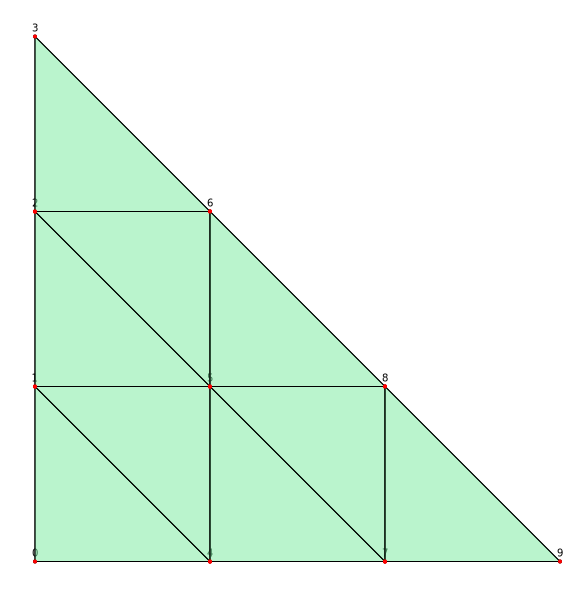

In [3]:
pm.display_svg(TT)

This triangulation is very special in that it is <i>foldable</i> (or "balanced"), i.e., the dual graph is bipartite.  This means that the triangles can be colored, say, black and white such that no two triangles of the same color share an edge.  The <i>signature</i> is the absolute difference of the black triangles minus the white triangles (of odd normalized volume).

In [4]:
T = pm.topaz.GeometricSimplicialComplex(COORDINATES = A[:,2:end], FACETS = F)
@show T.FOLDABLE
@show T.SIGNATURE

T.FOLDABLE = true
T.SIGNATURE = 3


3

It is a fact that the vertices of a foldable triangulation can be colored by $d+1$ colors (such that vertices of the same color do not share an edge), where $d$ is the dimension.  Here $d=2$.

The implementation uses HomotopyContinuation and polymake.  The function below is used for converting polynomials.

In [5]:
import HomotopyContinuation
const HC=HomotopyContinuation

function hc_poly(f, vars)
    M = pm.monomials_as_matrix(f)
    monomials_as_matrix = [prod(vars.^m) for m in eachrow(M)]
    coeffs = convert.(Int, pm.coefficients_as_vector(f))
    sum(map(*, coeffs, monomials_as_matrix))
end;

Now a <i>Wronski polynomial</i> has the given lattice points as exponents, and only one coefficient per color class of vertices of the triangulation.

A <i>Wronski system</i> consists of $d$ Wronski polynomials with respect to the same lattice points and triangulation.  It is assumed that the coefficients are generic.

The <i>Wronski center ideal</i> is relevant for checking a necessary condition for that Theorem 3.5 of Soprunova & Sottile.  This involves the triangulation and some lifting function.  

In [6]:
I = pm.polytope.wronski_center_ideal(A, λ)
HC.@polyvar x[1:2] s;
HC_I = [hc_poly(f, [x;s]) for f in I.GENERATORS]

3-element Array{DynamicPolynomials.Polynomial{true,Int64},1}:
 x₁³s¹⁵ + s¹² + x₁x₂s + x₂³
 x₁²s⁹ + x₂s³ + x₁x₂²
 x₁s⁸ + x₁²x₂s⁵ + x₂²

The Wronski center ideal is generated by $d+1$, here 3, polynomials which collect the terms of the color classes and a new variable, $s$, for the lifting function.

In [7]:
@time res = HC.solve(HC_I; start_system = :polyhedral, only_torus = true)

Tracking 54 paths... 100%|██████████████████████████████| Time: 0:00:05
  # paths tracked:                  54
  # non-singular solutions (real):  54 (2)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         54 (2)
 22.855212 seconds (60.34 M allocations: 2.947 GiB, 2.85% gc time)


Result with 54 solutions
• 54 paths tracked
• 54 non-singular solutions (2 real)
• random_seed: 0xefb37c3b
• start_system: :polyhedral


We get 54 complex roots, out of which two are real.  One of the conditions to check asks that there are no real roots between $0$ and $1$.  See the Soprunova-Sottile paper for details.

In [8]:
points = HC.real_solutions(res)

2-element Array{Array{Float64,1},1}:
 [-0.21175800954334498, -215.7226007931453, 4.411470567441928]
 [-0.6943590430596772, -0.41424188458258865, -0.8952189506082182]

The main result of Soprunova & Sottile says that, if all the conditions are satisfied, then a Wronski system has at least signature many real solutions.  In this case: 3.

In [9]:
c = Vector{pm.Rational}[[19,8,-19], [39,7,42]];
W = pm.polytope.wronski_system(A, λ, c, 1)
HC_W = [hc_poly(f, x) for f in W.GENERATORS];
W_res = HC.solve(HC_W)

Tracking 9 paths... 100%|███████████████████████████████| Time: 0:00:02
  # paths tracked:                  9
  # non-singular solutions (real):  9 (3)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         9 (3)


Result with 9 solutions
• 9 paths tracked
• 9 non-singular solutions (3 real)
• random_seed: 0x5b02c35c
• start_system: :polyhedral


## Visualization

Julia has powerful libraries for visualization.  Here we are using ImplicitPlots to see the three points of intersection,

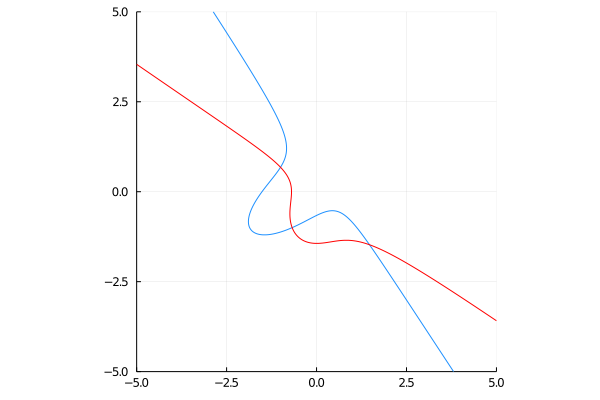

In [10]:
using ImplicitPlots, Plots
p = plot(legend=false);

implicit_plot!(p, HC_W[1]);
implicit_plot!(p, HC_W[2]; linecolor=:red);
p